<a href="https://colab.research.google.com/github/zh1212121/NLP-Assn-2/blob/main/Assignment_2_SVM_Zheng_Wanyu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[CS605 NLP] Assignment 2_SVM




Zheng Wanyu (wanyu.zheng.2020@mitb.smu.edu.sg)

##1. Import Libraries & Check Version

In [359]:
#!python -V

In [360]:
!pip install scikit-learn==0.21
!pip uninstall numpy -y
!pip install numpy==1.19.0
!pip install nltk

Uninstalling numpy-1.19.0:
  Successfully uninstalled numpy-1.19.0
  Using cached https://files.pythonhosted.org/packages/a8/31/e2c3eda7afe7dab08e1f24767b8e38ff2f30dc82bd74aa3a5324c550366a/numpy-1.19.0-cp37-cp37m-manylinux2010_x86_64.whl
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.19.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [361]:
import numpy as np
import pandas as pd
import torch
import re
import string
import nltk
import sklearn as sk
import matplotlib.pyplot as plt
import time
import pickle

from sklearn import model_selection, metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.utils import shuffle


from google.colab import files

In [362]:
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [363]:
seed = 1234

In [364]:
print(np.__version__)
print(pd.__version__)
print(sk.__version__)

1.19.5
1.1.5
0.21.0


In [365]:
#from google.colab import drive
#drive.mount('drive')

##2. Import Dataset

In [366]:
#import given datasets
url_imdb = "https://raw.githubusercontent.com/zh1212121/NLP-Assn-2/main/Train.csv"
imdb_raw = pd.read_csv(url_imdb)

url_valid = "https://raw.githubusercontent.com/zh1212121/NLP-Assn-2/main/Valid.csv"
valid_raw = pd.read_csv(url_valid)

In [367]:
imdb_raw.head()

,Text,Label
0,"In Iran, women are not permitted to attend men...",1
1,Los Angeles TV news reporter Jennifer (the bea...,1
2,"I grew up in Royersford, Pa. The town where Je...",1
3,"It was poorly shot. Looks Like a rush job, las...",0
4,My skateboarding career ended in 1974 when my ...,1


In [368]:
valid_raw.head()

,Text,Label
0,I have just seen this movie and have not read ...,0
1,Lynch. The man has some really great stuff! He...,0
2,"Director John Madden, of Shakespeare in Love f...",0
3,This game is very good for the n64. You can sk...,1
4,"First of all ""Mexican werewolf in Texas"" is no...",0


In [369]:
print("Shape of train dataset:", imdb_raw.shape)
print("No. of unique values in train dataset:\n",imdb_raw.nunique(), "\n")
print("Shape of test dataset:", valid_raw.shape)
print("No. of unique values in test dataset:\n",valid_raw.nunique())

Shape of train dataset: (5000, 2)
No. of unique values in train dataset:
 Text     4993
Label       2
dtype: int64 

Shape of test dataset: (2000, 2)
No. of unique values in test dataset:
 Text     2000
Label       2
dtype: int64


In [370]:
#check for any null data
print(imdb_raw.isnull().sum())
print(valid_raw.isnull().sum())

#no null data in the given datasets

Text     0
Label    0
dtype: int64
Text     0
Label    0
dtype: int64


In [371]:
#inspect review length
for i in range(5):
  print("Length of review", i, ":", len(imdb_raw["Text"][i].split()))

avg_review_length = imdb_raw["Text"].apply(lambda x: len(x.split())).mean()
print("Average length of review: ", avg_review_length)

max_review_length = max(imdb_raw['Text'].apply(lambda x: len(x.split())))
print("Max length of review: ", max_review_length)

Length of review 0 : 622
Length of review 1 : 227
Length of review 2 : 124
Length of review 3 : 64
Length of review 4 : 438
Average length of review:  232.1402
Max length of review:  1316


In [372]:
imdb_raw['Label'].value_counts()
#the dataset is balanced

1    2500
0    2500
Name: Label, dtype: int64

##3. Data Preprocessing

1. lowercase<br />
2. remove \<br /><br />
3. remove url (http://)<br />
4. decontraction
5. remove punctuation (tested effect)<br />
6. remove non-char words/special char including digits (test effect)<br />
7. remove stopwords (tested effect)<br />
8. lemmatization (tested effect)
9. remove single char
10. reduce multiple whitespaces


In [373]:
#change text to lower case
def convert_to_lower(text):
  return text.lower()

In [374]:
#remove <br />
def remove_newline(text):
  return re.sub('<br />', '', text)

In [375]:
#remove http:// links
def remove_link(text):
  return re.sub(r'http[s]?://\S+\b', '', text)

In [376]:
#decontraction
def decontract(text):
  text = re.sub(r"won\'t", " will not", text)
  text = re.sub(r"won\'t've", " will not have", text)
  text = re.sub(r"can\'t", " can not", text)
  text = re.sub(r"don\'t", " do not", text)
    
  text = re.sub(r"can\'t've", " can not have", text)
  text = re.sub(r"ma\'am", " madam", text)
  text = re.sub(r"let\'s", " let us", text)
  text = re.sub(r"ain\'t", " am not", text)
  text = re.sub(r"shan\'t", " shall not", text)
  text = re.sub(r"sha\n't", " shall not", text)
  text = re.sub(r"o\'clock", " of the clock", text)
  text = re.sub(r"y\'all", " you all", text)

  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"n\'t've", " not have", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r"\'d've", " would have", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'ll've", " will have", text)
  text = re.sub(r"\'t", " not", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"\'m", " am", text)
  text = re.sub(r"\'re", " are", text)
  return text

#reference:
#https://www.kaggle.com/faressayah/sentiment-model-with-tensorflow-transformers

In [377]:
#remove punctuation
print(string.punctuation)

def remove_punc(text):
  return text.translate(str.maketrans('', '', string.punctuation))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [378]:
#remove special characters & numbers 
def remove_special(text, remove_punc = True, remove_digits=True):
  if remove_punc:
    if remove_digits:
      pattern=r'[^a-zA-z\s]'
      text=re.sub(pattern,'',text)
    else:
      pattern=r'[^a-zA-z0-9\s]'
      text=re.sub(pattern,'',text)
  else:
    if remove_digits:
      pattern=r'[^a-zA-z\!\"#$%&\'()*+,-.//:;<=>\?@[\]^_`{|}~\s'
      text=re.sub(pattern,'',text)
    else:
      pattern=r'[^a-zA-z0-9\!\"#$%&\'()*+,-.//:;<=>\?@[\]^_`{|}~\s'
      text=re.sub(pattern,'',text)
  return text

In [379]:
#view stopword list
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [380]:
#define my own stopword list to exclude those stopwards that could change meaning of a sentence, eg. can't, doesn't
stopword_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", 
                 "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 
                 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
                 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 
                 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 
                 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 
                 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 
                 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 
                 'up', 'down', 'in', 'out', 'on', 'off', 'further', 'then', 'here', 'there', 'when', 'where', 
                 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more','other', 'some', 'such', 'own', 
                 'same', 'so', 'than', 'too', 's', 't', 'can', 'will', 'just', 'now', 'd', 'll', 'm', 'o', 
                 're', 've', 'y', ]
print(stopword_list)

def remove_stopword(text):
  result = ' '.join([i for i in text.split() if not i in stopword_list])
  return result

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'further', 'then', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'other', 'some', 'such', 'own', 'same', 'so', 'than', 'too', 's', 't', 'can', 'will', 'just', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y

In [381]:
#Lemmatization
def lemmatize(text):
  lemmatizer = WordNetLemmatizer()
  tokens = word_tokenize(text)
  result = ' '.join([lemmatizer.lemmatize(w) for w in tokens])
  return result

In [382]:
#remove single character as it generally has less meaning
def remove_single_char(text):
  return re.sub(r'\b\w\b', '', text)

In [383]:
#reduce multiple whitespaces to single space
def reduce_space(text):
  return re.sub(r'\s+', ' ', text).strip()

In [384]:
def clean_text(text, remove_punc = False, remove_digits = False):
  text = convert_to_lower(text)
#  print(text)
  text = remove_newline(text)
#  print(text)
  text = remove_link(text)
#  print(text)
  text = decontract(text)
#  print(text)
  text = remove_special(text, remove_punc, remove_digits)
#  print(text)
  text = remove_stopword(text)
#  print(text)  
#  text = lemmatize(text)
#  print(text)
  text = remove_single_char(text)
#  print(text)
  text = reduce_space(text)
#  print(text)

  return text

In [385]:
punc = True
dig = False

In [386]:
#clean the train data and store in new column "Clean_Text"
imdb_raw['Clean_text'] = imdb_raw["Text"].apply(clean_text, remove_punc = punc, remove_digits = dig)

In [387]:
avg_review_length_clean = imdb_raw["Clean_text"].apply(lambda x: len(x.split())).mean()
print("Average length of review after preprocessing: ", avg_review_length_clean)

max_review_length_clean = max(imdb_raw['Clean_text'].apply(lambda x: len(x.split())))
print("Max length of review after preprocessing: ", max_review_length_clean)

Average length of review after preprocessing:  122.7354
Max length of review after preprocessing:  658


In [388]:
imdb_raw.head()

,Text,Label,Clean_text
0,"In Iran, women are not permitted to attend men...",1,iran women not permitted attend men sporting e...
1,Los Angeles TV news reporter Jennifer (the bea...,1,los angeles tv news reporter jennifer beautifu...
2,"I grew up in Royersford, Pa. The town where Je...",1,grew royersford pa town jerry market remember ...
3,"It was poorly shot. Looks Like a rush job, las...",0,poorly shot looks like rush job last minute ca...
4,My skateboarding career ended in 1974 when my ...,1,skateboarding career ended 1974 twobyfour skat...


In [389]:
#clean the validation dataset and store in new column "Clean_text"
valid_raw['Clean_text'] = valid_raw["Text"].apply(clean_text, remove_punc = punc, remove_digits = dig)

In [390]:
valid_raw.head()

,Text,Label,Clean_text
0,I have just seen this movie and have not read ...,0,seen movie not read book good thing movie part...
1,Lynch. The man has some really great stuff! He...,0,lynch man really great stuff knows disturb us ...
2,"Director John Madden, of Shakespeare in Love f...",0,director john madden shakespeare love fame giv...
3,This game is very good for the n64. You can sk...,1,game very good n64 skate tony hawk bob burnqui...
4,"First of all ""Mexican werewolf in Texas"" is no...",0,first mexican werewolf texas not werewolf movi...


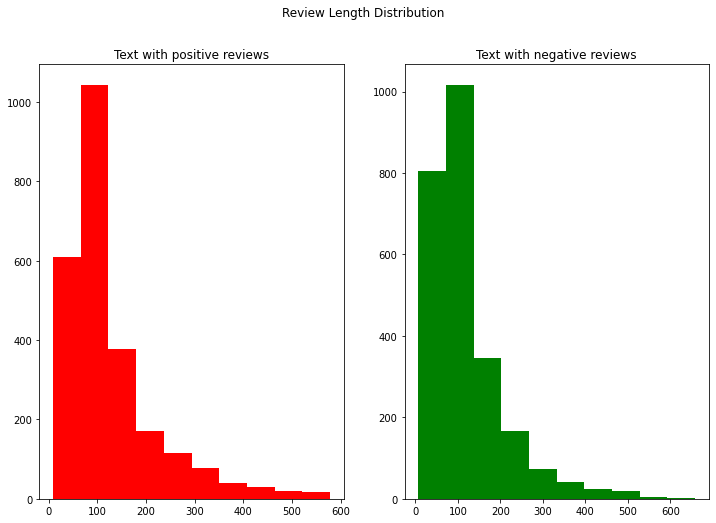

In [391]:
#inspect review length distribution
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=imdb_raw[imdb_raw['Label']==1]['Clean_text'].apply(lambda x: len(x.split()))
ax1.hist(text_len,color='red')
ax1.set_title('Text with positive reviews')
text_len=imdb_raw[imdb_raw['Label']==0]['Clean_text'].apply(lambda x: len(x.split()))
ax2.hist(text_len,color='green')
ax2.set_title('Text with negative reviews')
fig.suptitle('Review Length Distribution')
plt.show()


#4. Modelling - SVM

###4.1 Prepare Train Test Data

In [392]:
train = pd.DataFrame({'Clean_text': imdb_raw['Clean_text'], 'Label': imdb_raw['Label']})
print(train.shape)
train.head()

(5000, 2)


,Clean_text,Label
0,iran women not permitted attend men sporting e...,1
1,los angeles tv news reporter jennifer beautifu...,1
2,grew royersford pa town jerry market remember ...,1
3,poorly shot looks like rush job last minute ca...,0
4,skateboarding career ended 1974 twobyfour skat...,1


In [393]:
test = pd.DataFrame({'Clean_text': valid_raw['Clean_text'], 'Label': valid_raw['Label']})
print(test.shape)
test.head()

(2000, 2)


,Clean_text,Label
0,seen movie not read book good thing movie part...,0
1,lynch man really great stuff knows disturb us ...,0
2,director john madden shakespeare love fame giv...,0
3,game very good n64 skate tony hawk bob burnqui...,1
4,first mexican werewolf texas not werewolf movi...,0


In [394]:
train.to_csv('Train_processed.csv')
#!cp test_output.csv "drive/My Drive/"
files.download('Train_processed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [395]:
test.to_csv('Valid_processed.csv')
files.download('Valid_processed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [346]:
train = shuffle(train, random_state=seed)

In [347]:
x_train = train['Clean_text']
y_train = train['Label']
x_test = test['Clean_text']
y_test = test['Label']

###4.2 Model Building

In [348]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

#train_vectors = vectorizer.fit_transform(train['Clean_text'])
#test_vectors = vectorizer.transform(test['Clean_text'])

In [349]:
kfolds = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [351]:
np.random.seed(seed)

#pipeline_svm = make_pipeline([('tfidf', TfidfTransformer())], 
#                            svm.SVC(probability=True, kernel="linear", class_weight="balanced"))

pipeline_svm = make_pipeline(vectorizer, 
                            svm.SVC(probability=True, kernel="linear", class_weight="balanced"))


grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="f1_macro",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(x_train, y_train)
grid_svm.score(x_test, y_test)

#grid_svm.fit(train_vectors, train['Label'])
#grid_svm.score(test_vectors, test['Label'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 11.5min finished


0.8754526408666896

In [352]:
y_pred = grid_svm.predict(x_test)
#print(y_pred)

###4.3 Evaluation

In [356]:
print('classification report on test data is shown below:')
report = classification_report(y_test, y_pred)
print(report)

f1_score = sk.metrics.f1_score(y_test, y_pred)
print('f1 score of the model on test data is:', round(f1_score, 2))
print(f1_score)

accuracy = sk.metrics.accuracy_score(y_test, y_pred)
print('accuracy of the model on test data is:', round(accuracy,2))
print(accuracy)

classification report on test data is shown below:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       999
           1       0.86      0.89      0.88      1001

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000

f1 score of the model on test data is: 0.88
0.8778813143697891
accuracy of the model on test data is: 0.88
0.8755


###4.4 Save model

In [357]:
pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))

In [358]:
filename = 'model.sav'
pickle.dump(grid_svm, open(filename, 'wb'))

In [397]:
!pip install -r requirements.txt